# <b>Take file name of the text to be analyzed as input</b>

In [146]:
import easygui
file_name = easygui.enterbox("Enter the file location of the text draft to be analyzed")
with open(file_name, 'r') as file:
    doc = file.read().replace('\n', '') 
orig_text =doc

# <b>Importing Libraries</b>

In [147]:
# Libraries for text preprocessing
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer

# <b>Text Preprocessing</b>

In [148]:

#Remove punctuations
doc = re.sub('[^a-zA-Z]', ' ', doc)

#Convert to lowercase
doc = doc.lower()

#remove tags
doc=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",doc)

# remove special characters and digits
doc=re.sub("(\\d|\\W)+"," ",doc)

##Convert to list from string
doc = doc.split()
# text=doc
##Creating a list of stop words and adding custom stopwords
stop_words = set(stopwords.words("english"))
##Creating a list of custom stopwords
new_words = ["medium", "show", "result", "also", "previously","article","the","to","of","for","in","our","from","on","it","also"]
stop_words = stop_words.union(new_words)
##Stemming
# ps=PorterStemmer()
#Lemmatisation
lem = WordNetLemmatizer()
doc = [lem.lemmatize(word) for word in doc if not word in  
            stop_words] 
doc = " ".join(doc)

# print(doc)

# <b>Preprocessed Text</b>

In [149]:
print(doc)

typical day scrolling google news feed tell u election policy favoured political party intends implement yesterday match favourite team lost box office collection movie watched last weekend harmless skimming sharing clicking almost every day wait lift reach floor grapple insomnia try stay awake boring morning lecture u fail notice whatever seeing reading always u content internet offer u already curated intelligent force behind screen ensure match interest important question arises personalisation extent actually required kind curation filtering actually personal interest society whole today era internet rule life ai future getting answer question prime importance according wikipedia term filter bubble mean state intellectual isolation allegedly personalised search website algorithm selectively guess information user would like see based information user location past click behaviour search history prime example include google personalised search facebook personalised news stream user 

# <b>Creating Word Cloud for the Document</b>

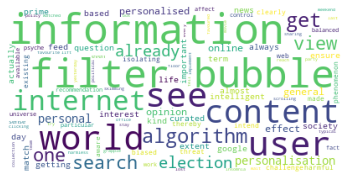

In [150]:
#Word cloud
# %pip install wordcloud --user
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
# for index in range(len(dataset)):
        # temp += df['A'].iloc[index] + df['B'].iloc[index]
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(doc))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word.png", dpi=900)

# <b>Creating list of Candidate Keywords</b>

In [151]:
from sklearn.feature_extraction.text import CountVectorizer

n_gram_range = (1,2)
# stop_words = "english"

# Extract candidate words/phrases
count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([doc])
candidates = count.get_feature_names()

# <b>Generating BERT Embeddings</b>

In [152]:

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode([doc])
candidate_embeddings = model.encode(candidates)

# <b>Finding Candidates most similar to Document using Cosine Similarity</b>

In [153]:
import numpy as np
import itertools
from sklearn.metrics.pairwise import cosine_similarity

top_n = 10
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]
print("Keywords :\n")
print(keywords)

Keywords :

['cyber warfare', 'last weekend', 'internet activist', 'google', 'search facebook', 'include google', 'website algorithm', 'google personalised', 'scrolling google', 'google news']


# <b>Max Sum Similarity Algo</b>

In [154]:


def max_sum_sim(doc_embedding, word_embeddings, words, top_n, nr_candidates):
    # Calculate distances and extract keywords
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    distances_candidates = cosine_similarity(candidate_embeddings, 
                                            candidate_embeddings)

    # Get top_n words as candidates based on cosine similarity
    words_idx = list(distances.argsort()[0][-nr_candidates:])
    words_vals = [candidates[index] for index in words_idx]
    distances_candidates = distances_candidates[np.ix_(words_idx, words_idx)]

    # Calculate the combination of words that are the least similar to each other
    min_sim = np.inf
    candidate = None
    for combination in itertools.combinations(range(len(words_idx)), top_n):
        sim = sum([distances_candidates[i][j] for i in combination for j in combination if i != j])
        if sim < min_sim:
            candidate = combination
            min_sim = sim

    return [words_vals[idx] for idx in candidate]

# <b>Maximal Marginal Relevance</b>

In [155]:


def mmr(doc_embedding, word_embeddings, words, top_n, diversity):

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(top_n - 1):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(word_similarity[candidates_idx][:, keywords_idx], axis=1)

        # Calculate MMR
        mmr = (1-diversity) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

# <b>Keywords after applying MSS Algo :</b>

In [156]:
keywords1=max_sum_sim(doc_embedding, candidate_embeddings, candidates, top_n=10, nr_candidates=20)
print(keywords1)

['wikipedia', 'leading cyber', 'morning lecture', 'yesterday match', 'facebook personalised', 'universe internet', 'cyber warfare', 'last weekend', 'search facebook', 'include google']


# <b>Keywords after applying MMR Algo :</b>

In [157]:
keywords2=mmr(doc_embedding, candidate_embeddings, candidates, top_n=10, diversity=0.7)
print(keywords2)

['google news', 'match favourite', 'morning lecture', 'grapple insomnia', 'last weekend', 'election policy', 'web always', 'collection movie', 'improve online', 'home isolating']


# <b>Highlighting Keywords in the Text :</b>

In [158]:

doc1=orig_text
for word in keywords:
    if len(word.split())==1:
        doc1=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc1,flags=re.I)
    else:
        word1=word.split()[0]
        word2=word.split()[1]
        doc1=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc1,flags=re.I)
        doc1=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc1,flags=re.I)
# print(doc1)

In [159]:
doc2=orig_text
for word in keywords1:
    # print(len(word))
    if len(word.split())==1:
        doc2=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc2,flags=re.I)
    else:
        # print(word)
        word1=word.split()[0]
        word2=word.split()[1]
        doc2=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc2,flags=re.I)
        doc2=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc2,flags=re.I)
# print(doc2)

In [160]:
doc3=orig_text
for word in keywords2:
    if len(word.split())==1:
        doc3=re.sub(word,'\033[34m' + str(word) + '\033[0m',doc3,flags=re.I)
    else:
        word1=word.split()[0]
        word2=word.split()[1]
        doc3=re.sub(word1,'\033[34m' + str(word1) + '\033[0m',doc3,flags=re.I)
        doc3=re.sub(word2,'\033[34m' + str(word2) + '\033[0m',doc3,flags=re.I)
# print(doc3)

# <b>Tags Suggested as a Result of Keyword Extraction:</b>

In [161]:
print("BERT Model \n")
print("Before Applying Diversification Algorithms\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords):
    print(number+1, letter)
print("\n Article : \n")
print(doc1,"\n\n---------------------------------------------------------------------------------------------------------------\n")

print("After Applying Diversification Algorithm - Max sum Similarity\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords1):
    print(number+1, letter)
print("\n Article : \n")
print(doc2,"\n\n---------------------------------------------------------------------------------------------------------------\n")

print("After Applying Diversification Algorithm - Maximal Marginal Relevance\n")
print("Keywords : \n" )
for number, letter in enumerate(keywords2):
    print(number+1, letter)
print("\n Article : \n")
print(doc3,"\n\n----------------------------------------------------------------------------------------------------------------\n")



BERT Model 

Before Applying Diversification Algorithms

Keywords : 

1 cyber warfare
2 last weekend
3 internet activist
4 google
5 search facebook
6 include google
7 website algorithm
8 google personalised
9 scrolling google
10 google news

 Article : 

It is a typical day and we are scrolling through our google news feed as it tells us about the elections and the policies our favoured political party intends to implement, yesterday’s match that our favourite team lost by 3-1, and the box office collection of the movie we watched last weekend. We do this ‘harmless’ skimming and sharing and clicking almost every day as we wait for the lift to reach our floor, to grapple with insomnia, or to try to stay awake in a boring morning lecture. But what most of us fail to notice is that whatever we are seeing or reading is always about ‘us’. The content that the internet offers us is already curated by some ‘intelligent’ forces behind our screens to ensure that it matches with our interests. B

# <b>Word Frequency :</b>

In [162]:
#Fetch wordcount for each article
word_count = len(str(doc).split(" "))
word_count

477

# <b>Identify common unigrams, bigrams, and trigrams</b>

In [163]:
#Identify common words
import pandas as pd
freq = pd.Series(doc.split()).value_counts()[:20]
freq

u                  20
information         9
bubble              9
filter              9
see                 6
user                6
world               6
internet            5
algorithm           5
content             5
get                 5
search              4
view                4
one                 4
opinion             3
personal            3
already             3
personalisation     3
election            3
personalised        3
dtype: int64

[('u', 20), ('filter', 9), ('bubble', 9), ('information', 9), ('user', 6), ('see', 6), ('world', 6), ('content', 5), ('internet', 5), ('algorithm', 5), ('get', 5), ('search', 4), ('view', 4), ('one', 4), ('election', 3), ('already', 3), ('personalisation', 3), ('personal', 3), ('personalised', 3), ('opinion', 3)]


[Text(0, 0, 'u'),
 Text(0, 0, 'filter'),
 Text(0, 0, 'bubble'),
 Text(0, 0, 'information'),
 Text(0, 0, 'user'),
 Text(0, 0, 'see'),
 Text(0, 0, 'world'),
 Text(0, 0, 'content'),
 Text(0, 0, 'internet'),
 Text(0, 0, 'algorithm'),
 Text(0, 0, 'get'),
 Text(0, 0, 'search'),
 Text(0, 0, 'view'),
 Text(0, 0, 'one'),
 Text(0, 0, 'election'),
 Text(0, 0, 'already'),
 Text(0, 0, 'personalisation'),
 Text(0, 0, 'personal'),
 Text(0, 0, 'personalised'),
 Text(0, 0, 'opinion')]

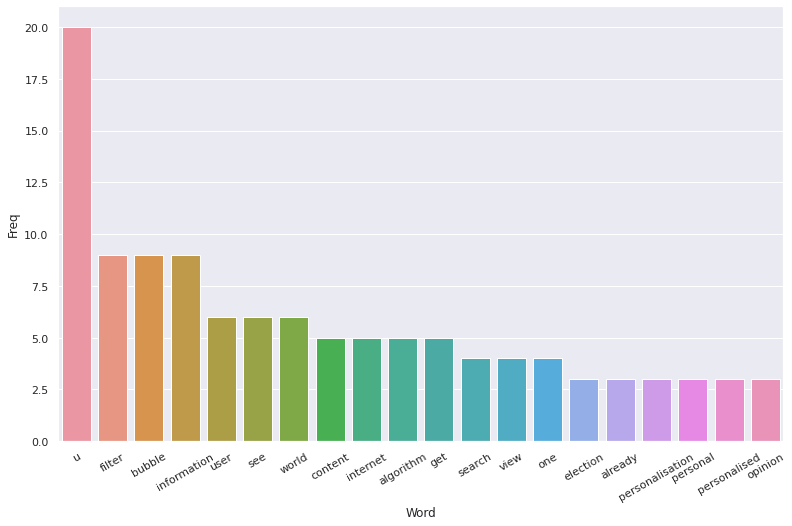

In [164]:
#Most frequently occuring words
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    counts_x = sorted(counts.items(), key=lambda kv: kv[1],reverse=True)
    print(counts_x[:20])
    return counts_x
#Convert most freq words to dataframe for plotting bar plot

top_words = word_count(doc)[:20]
common_words=top_words
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
# %pip install seaborn --user
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [165]:
!pip install textblob --user
from textblob import TextBlob

You should consider upgrading via the 'pip install --upgrade pip' command.


In [166]:

 
# Function to generate n-grams from sentences.
def extract_ngrams(data, num):
    n_grams = TextBlob(data).ngrams(num)
    return [ ' '.join(grams) for grams in n_grams]
 
bi=extract_ngrams(doc, 2)
tri=extract_ngrams(doc, 3)


# print("2-gram: ", extract_ngrams(doc, 2))
# print("3-gram: ", extract_ngrams(doc, 3))


[Text(0, 0, 'filter bubble'),
 Text(0, 0, 'u election'),
 Text(0, 0, 'term filter'),
 Text(0, 0, 'personalised search'),
 Text(0, 0, 'information user'),
 Text(0, 0, 'already existing'),
 Text(0, 0, 'world aware'),
 Text(0, 0, 'affect psyche'),
 Text(0, 0, 'bubble effect'),
 Text(0, 0, 'typical day'),
 Text(0, 0, 'day scrolling'),
 Text(0, 0, 'scrolling google'),
 Text(0, 0, 'google news'),
 Text(0, 0, 'news feed'),
 Text(0, 0, 'feed tell'),
 Text(0, 0, 'tell u'),
 Text(0, 0, 'election policy'),
 Text(0, 0, 'policy favoured'),
 Text(0, 0, 'favoured political'),
 Text(0, 0, 'political party')]

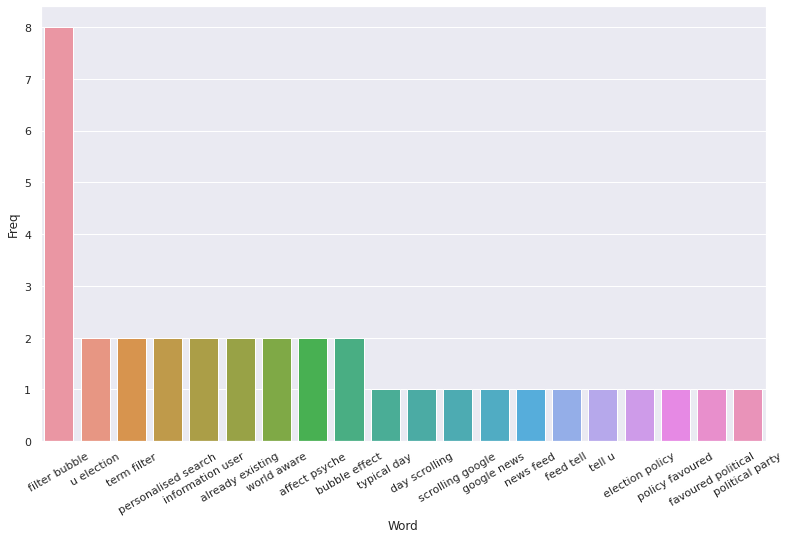

In [167]:
#Most frequently occuring bigrams
def word_count(bi):
    counts = dict()
    # words = str.split()

    for word in bi:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    counts_x = sorted(counts.items(), key=lambda kv: kv[1],reverse=True)
    # print(counts_x[:20])
    return counts_x
#Convert most freq words to dataframe for plotting bar plot
top_words = word_count(bi)[:20]
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
# %pip install seaborn --user
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

[Text(0, 0, 'term filter bubble'),
 Text(0, 0, 'filter bubble effect'),
 Text(0, 0, 'typical day scrolling'),
 Text(0, 0, 'day scrolling google'),
 Text(0, 0, 'scrolling google news'),
 Text(0, 0, 'google news feed'),
 Text(0, 0, 'news feed tell'),
 Text(0, 0, 'feed tell u'),
 Text(0, 0, 'tell u election'),
 Text(0, 0, 'u election policy'),
 Text(0, 0, 'election policy favoured'),
 Text(0, 0, 'policy favoured political'),
 Text(0, 0, 'favoured political party'),
 Text(0, 0, 'political party intends'),
 Text(0, 0, 'party intends implement'),
 Text(0, 0, 'intends implement yesterday'),
 Text(0, 0, 'implement yesterday match'),
 Text(0, 0, 'yesterday match favourite'),
 Text(0, 0, 'match favourite team'),
 Text(0, 0, 'favourite team lost')]

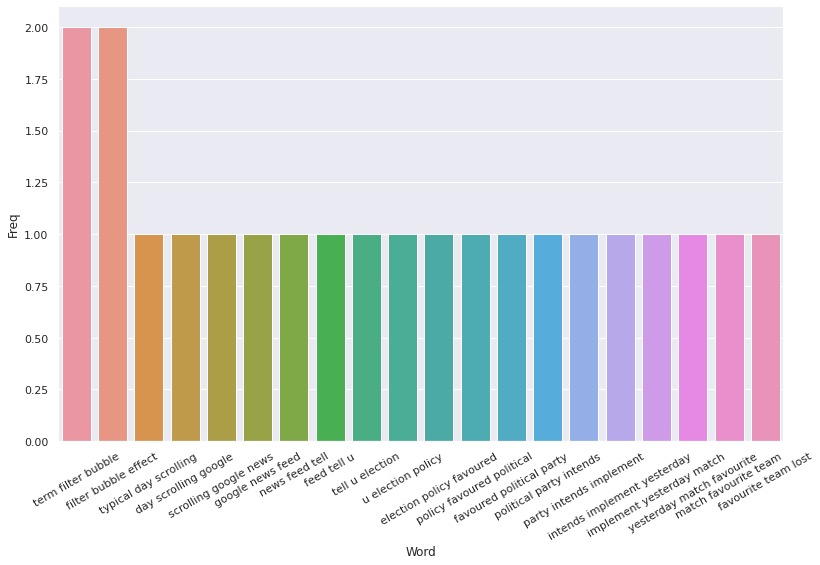

In [168]:
#Most frequently occuring trigrams
def word_count(tri):
    counts = dict()
    # words = str.split()

    for word in tri:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    counts_x = sorted(counts.items(), key=lambda kv: kv[1],reverse=True)
    # print(counts_x[:20])
    return counts_x
#Convert most freq words to dataframe for plotting bar plot
top_words = word_count(tri)[:20]
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
# %pip install seaborn --user
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

# <b>Identify uncommon words</b>

In [169]:
#Identify uncommon words
freq1 =  pd.Series(doc.split()).value_counts()[-20:]
freq1

amplifying       1
realize          1
curation         1
click            1
whether          1
parser           1
hooked           1
ecosystem        1
wonder           1
becomes          1
warfare          1
someone          1
location         1
collection       1
favourite        1
last             1
story            1
preference       1
personalising    1
intend           1
dtype: int64

# <b>Analyze sentiment underlying the text</b>

<i>Sentiment Analysis can help us decipher the mood and emotions underlying a piece of text and gather insightful information regarding the context. TextBlob is a python library for Natural Language Processing (NLP). TextBlob returns <b>polarity</b> and <b>subjectivity</b> of a sentence.</i>
<ul>
<li> Polarity lies between [-1,1], -1 defines a negative sentiment and 1 defines a positive sentiment.
<li> Subjectivity lies between [0,1]. Subjectivity quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.
</ul>

In [170]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

subjectivity=getSubjectivity(orig_text)
polarity=getPolarity(orig_text)
sentiment=getAnalysis(polarity)

print("Sentiment type : ",sentiment)
print("Subjectivity : ",subjectivity)
print("Polarity: ",polarity)

Sentiment type :  Positive
Subjectivity :  0.5179748062015503
Polarity:  0.11308139534883721


# <b>Analyze the tone/emotions underlying the text</b>

<i>Text2emotion is the python package developed to find the appropriate emotions embedded in the text data. Tracking these tone signals can help writers to know how their content's tone would be perceived by the audience so that they can alter it based on their use case. </i>

In [171]:
#Install package using pip
!pip install text2emotion --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [172]:
#Import the module
import text2emotion as te

In [173]:
emo=te.get_emotion(orig_text)

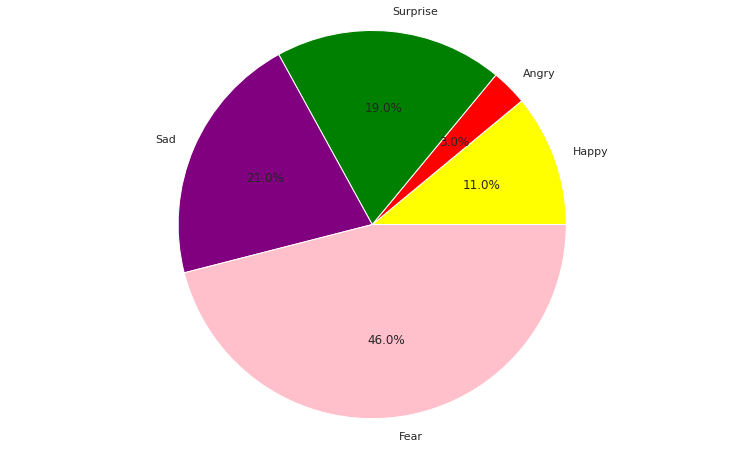

In [174]:
labels = []
sizes = []
colors=['yellow','red','green','purple','pink']
for x, y in emo.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels=labels,autopct='%1.1f%%',colors=colors)

plt.axis('equal')
plt.show()

# <b>Analyze text readability</b>

<i>In NLP, it is required to analyse words and sentences to determine the difficulty of the text. Readability Scores are generally grade levels on particular scales, which rates the text as to whats the difficulty of that particular text. It assists the writer in improving the text to make it understandable for a larger audience, thus making content engaging. Readability is the ease with which a reader can understand a written text. In natural language, the readability of text depends on its content (the complexity of its vocabulary and syntax). It focuses on the words we choose, and how we put them into sentences and paragraphs for the readers to comprehend.
Our main objective in writing is to pass along information that both the writer and the reader think is worthwhile. If we fail to convey that information, our efforts are wasted. In order to engage the reader, it’s critical to present information to them that they’ll gladly keep reading and be able to understand clearly. So, it is required that the content be easy enough to read and understand thus is as readable as possible.</i>

In [175]:
!pip install textstat --user

You should consider upgrading via the 'pip install --upgrade pip' command.


In [176]:
import textstat

print("Number of syllables : ",textstat.syllable_count(orig_text))
print("Number of lexicons : ",textstat.lexicon_count(orig_text, removepunct=True))
print("Number of sentences : ",textstat.sentence_count(orig_text))

Number of syllables :  1481
Number of lexicons :  952
Number of sentences :  28


# <b>The Flesch Reading Ease formula</b>
Score	Difficulty<br><br>
90-100	Very Easy<br>
80-89	Easy<br>
70-79	Fairly Easy<br>
60-69	Standard<br>
50-59	Fairly Difficult<br>
30-49	Difficult<br>
0-29	Very Confusing<br>

In [177]:

print(textstat.flesch_reading_ease(orig_text))




36.97


# <b>The Flesch-Kincaid Grade Level<b>

Returns the Flesch-Kincaid Grade of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [178]:
print(textstat.flesch_kincaid_grade(orig_text))

16.6


# <b>The Fog Scale (Gunning FOG Formula)<b>

Returns the FOG index of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [180]:
print(textstat.gunning_fog(orig_text))

17.72


# <b>The SMOG Index</b>

Returns the SMOG index of the given text. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [181]:

print(textstat.smog_index(orig_text))

15.7


# <b>Automated Readability Index</b>

Returns the ARI (Automated Readability Index) which outputs a number that approximates the grade level needed to comprehend the text.



In [182]:
print(textstat.automated_readability_index(orig_text))





18.6


# <b>The Coleman-Liau Index</b>

Returns the grade level of the text using the Coleman-Liau Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [183]:
print(textstat.coleman_liau_index(orig_text))

11.21


# <b>Linsear Write Formula</b>

Returns the grade level using the Linsear Write Formula. This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.

In [184]:
print(textstat.linsear_write_formula(orig_text))

19.0


# <b>Dale-Chall Readability Score</b>

Different from other tests, since it uses a lookup table of the most commonly used 3000 English words. Thus it returns the grade level using the New Dale-Chall Formula.

Score	        &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Understood by<br><br>
4.9 or lower	&nbsp &nbsp average 4th-grade student or lower<br>
5.0–5.9	average &nbsp 5th or 6th-grade student<br>
6.0–6.9	average &nbsp 7th or 8th-grade student<br>
7.0–7.9	average &nbsp 9th or 10th-grade student<br>
8.0–8.9	average &nbsp 11th or 12th-grade <br>
9.0–9.9	average &nbsp 13th to 15th-grade (college) student<br>

In [185]:
print(textstat.dale_chall_readability_score(orig_text))

8.49


# <b>Readability Consensus based upon all the above tests</b>

Based upon all the above tests, returns the estimated school grade level required to understand the text.

In [186]:
print(textstat.text_standard(orig_text, float_output=False))

18th and 19th grade


# <b> Suggest synonyms for most frequent words used in text</b>

In [187]:

from nltk.corpus import wordnet
# print(top_words)
#Creating a list 
for word in common_words:
    # print(type(word))
    synonyms = []
    for syn in wordnet.synsets(word[0]):
        for lm in syn.lemmas():
                synonyms.append(lm.name())#adding into synonyms
    if len(synonyms)>0:
        print ("Synonyms for ",word[0], "are : ",'\033[34m' + str(set(synonyms)) + '\033[0m',"\n")

Synonyms for  u are :  {'u', 'uranium', 'atomic_number_92', 'U', 'uracil'} 

Synonyms for  filter are :  {'trickle', 'sink_in', 'percolate', 'permeate', 'filter_out', 'filter', 'filtrate', 'separate_out', 'strain', 'dribble'} 

Synonyms for  bubble are :  {'ripple', 'gurgle', 'bubble', 'babble', 'burble', 'guggle', 'belch', 'eruct', 'burp', 'house_of_cards'} 

Synonyms for  information are :  {'information', 'data', 'selective_information', 'info', 'entropy'} 

Synonyms for  user are :  {'drug_user', 'substance_abuser', 'user', 'exploiter'} 

Synonyms for  see are :  {'control', 'visualise', 'look', 'ensure', 'understand', 'discover', 'interpret', 'image', 'encounter', 'determine', 'pick_up', 'realise', 'visit', 'reckon', 'witness', 'take_in', 'come_across', 'view', 'hear', 'find', 'regard', 'watch', 'visualize', 'catch', 'fancy', 'check', 'go_steady', 'consider', 'go_through', 'find_out', 'examine', 'go_out', 'picture', 'get_wind', 'figure', 'run_across', 'get_word', 'construe', 'envi

# <b> Suggesting additional tags using Word2vec</b>

<i>By building a Word2Vec model, we suggest tags in addition to the keywords of the text. These are existing 'Medium' tags and are related to text but may or may not be present in it. Taking tags for thousands of Medium posts and their corresponding publication's tags as corpus, we could find tags that are related to a given tag and recommend the related ones. We each set of co-occuring tags as a "sentence" and train a Word2Vec model on this data. There are many sets of tags on Medium that mean the same thing (e.g. “Science Fiction” and “SciFi”). Tags which mean the same thing are usually very close in the vector space. This could help us identify additional related tags already existing on Medium.</i>

In [188]:
# import pandas as pd
pd.options.mode.chained_assignment = None
# import numpy as np
# import re
# import nltk
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
%matplotlib inline

In [189]:
data = pd.read_csv('Medium_AggregatedData.csv',sep=',',encoding='utf-8',error_bad_lines=False)

In [190]:
data.head()
print(len(data))

279577


In [191]:
data.drop(data.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,23,25,26,27,28,29,30,31,32,33,34,35,38,39,41,42,43,44,45,46,47,48,49]], axis = 1, inplace = True) 

In [192]:
data.head()


,postId,tagsCount,text,title,uniqueSlug,publicationslug,publicationtags,slug
0,10007d3018fe,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",blockchain
1,10007d3018fe,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",samsung
2,10007d3018fe,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...",it
3,1000c43bcb97,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),introduction-3-1000c43bcb97,NaN,NaN,technology
4,1000c43bcb97,5,EPQ draft 1 (4844 words)\nhttps://upload.wikim...,EPQ draft 1 (4844 words),introduction-3-1000c43bcb97,NaN,NaN,robotics


In [193]:
data = data.groupby(['postId','tagsCount','text','title','uniqueSlug','publicationslug','publicationtags'])['slug'].apply(', '.join).reset_index()

In [194]:
data.head()

,postId,tagsCount,text,title,uniqueSlug,publicationslug,publicationtags,slug
0,10007d3018fe,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,"BLOCKCHAIN,ICO,ETHEREUM,ETHEREUM BLOCKCHAIN,TO...","blockchain, samsung, it"
1,1000b3d0d2,4,Democratizing Artificial intelligence by Democ...,Democratizing Artificial intelligence by Democ...,democratizing-artificial-intelligence-by-democ...,synapseai,"ETHEREUM,BLOCKCHAIN,ICO,AI,CRYPTOCURRENCY","blockchain, machine-learning, synapse, cryptoc..."
2,1002a55eca89,5,Can a robot love us better than another human ...,Can a robot love us better than another human ...,can-a-robot-love-us-better-than-another-human-...,crazy-wisdom,"MEDITATION,MINDFULNESS,YOGA,CREATIVITY,BUSINESS","robotics, meditation, therapy, artificial-inte..."
3,10034e4cf9a,5,\nThe State of Data Science and Machine Learni...,The State of Data Science and Machine Learning...,the-state-of-data-science-and-machine-learning...,towards-data-science,"DATA SCIENCE,MACHINE LEARNING,ARTIFICIAL INTEL...","data-science, data-visualization, python, mach..."
4,100385c6dfe0,3,Various Implementations of Collaborative Filte...,Various Implementations of Collaborative Filte...,various-implementations-of-collaborative-filte...,towards-data-science,"DATA SCIENCE,MACHINE LEARNING,ARTIFICIAL INTEL...","machine-learning, collaborative-filtering, tow..."


In [196]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    # print(val)
    sentence = regex.sub(' ', val).lower()
    # print(sentence)
    sentence = sentence.split(" ")
    # print(sentence)
    for word in list(sentence):
        if word in stop_words:
            sentence.remove(word)  
    # print(sentence)        
    sentence = " ".join(sentence)
    # print(sentence)
    return sentence
# clean_sentence("blockchain, samsung, it")

In [197]:
def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to Description"
    data = data.dropna(how="any")
    
    for col in ['slug']:
        data[col] = data[col].apply(clean_sentence)
    for col in ['publicationtags']:
        data[col] = data[col].apply(clean_sentence)
    return data

In [198]:
data = clean_dataframe(data)

In [199]:
data.head()

,postId,tagsCount,text,title,uniqueSlug,publicationslug,publicationtags,slug
0,10007d3018fe,5,"Private Business, Government and Blockchain\n\...","Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,blockchain ico ethereum ethereum blockchain to...,blockchain samsung
1,1000b3d0d2,4,Democratizing Artificial intelligence by Democ...,Democratizing Artificial intelligence by Democ...,democratizing-artificial-intelligence-by-democ...,synapseai,ethereum blockchain ico ai cryptocurrency,blockchain machine learning synapse cryptoc...
2,1002a55eca89,5,Can a robot love us better than another human ...,Can a robot love us better than another human ...,can-a-robot-love-us-better-than-another-human-...,crazy-wisdom,meditation mindfulness yoga creativity business,robotics meditation therapy artificial inte...
3,10034e4cf9a,5,\nThe State of Data Science and Machine Learni...,The State of Data Science and Machine Learning...,the-state-of-data-science-and-machine-learning...,towards-data-science,data science machine learning artificial intel...,data science data visualization python mach...
4,100385c6dfe0,3,Various Implementations of Collaborative Filte...,Various Implementations of Collaborative Filte...,various-implementations-of-collaborative-filte...,towards-data-science,data science machine learning artificial intel...,machine learning collaborative filtering tow...


In [200]:
data['text'] = data['publicationtags'].str.cat(data['slug'], sep =" ")

In [201]:
data.head()

,postId,tagsCount,text,title,uniqueSlug,publicationslug,publicationtags,slug
0,10007d3018fe,5,blockchain ico ethereum ethereum blockchain to...,"Private Business, Government and Blockchain",private-business-government-and-blockchain-100...,icobox-io,blockchain ico ethereum ethereum blockchain to...,blockchain samsung
1,1000b3d0d2,4,ethereum blockchain ico ai cryptocurrency bloc...,Democratizing Artificial intelligence by Democ...,democratizing-artificial-intelligence-by-democ...,synapseai,ethereum blockchain ico ai cryptocurrency,blockchain machine learning synapse cryptoc...
2,1002a55eca89,5,meditation mindfulness yoga creativity busines...,Can a robot love us better than another human ...,can-a-robot-love-us-better-than-another-human-...,crazy-wisdom,meditation mindfulness yoga creativity business,robotics meditation therapy artificial inte...
3,10034e4cf9a,5,data science machine learning artificial intel...,The State of Data Science and Machine Learning...,the-state-of-data-science-and-machine-learning...,towards-data-science,data science machine learning artificial intel...,data science data visualization python mach...
4,100385c6dfe0,3,data science machine learning artificial intel...,Various Implementations of Collaborative Filte...,various-implementations-of-collaborative-filte...,towards-data-science,data science machine learning artificial intel...,machine learning collaborative filtering tow...


In [202]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['text']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            while("" in word_list) : 
                word_list.remove("") 
    return corpus

In [203]:
corpus = build_corpus(data)        
corpus[0:10]

[['blockchain',
  'ico',
  'ethereum',
  'ethereum',
  'blockchain',
  'token',
  'sale',
  'blockchain',
  'samsung'],
 ['ethereum',
  'blockchain',
  'ico',
  'ai',
  'cryptocurrency',
  'blockchain',
  'machine',
  'learning',
  'synapse',
  'cryptocurrency'],
 ['meditation',
  'mindfulness',
  'yoga',
  'creativity',
  'business',
  'robotics',
  'meditation',
  'therapy',
  'artificial',
  'intelligence',
  'feelings'],
 ['data',
  'science',
  'machine',
  'learning',
  'artificial',
  'intelligence',
  'big',
  'data',
  'analytics',
  'data',
  'science',
  'data',
  'visualization',
  'python',
  'machine',
  'learning',
  'python3'],
 ['data',
  'science',
  'machine',
  'learning',
  'artificial',
  'intelligence',
  'big',
  'data',
  'analytics',
  'machine',
  'learning',
  'collaborative',
  'filtering',
  'towards',
  'data',
  'science'],
 ['vc',
  'startup',
  'nation',
  'israel',
  'machine',
  'learning',
  'radiology',
  'deep',
  'learning',
  'news',
  'portfoli

In [204]:
model = word2vec.Word2Vec(corpus, size=100, window=10, min_count=5, workers=4)


In [206]:
from sklearn.externals import joblib 

# Save the model as a pickle in a file 
joblib.dump(model, 'w2v.pkl') 




['w2v.pkl']

In [207]:
from sklearn.externals import joblib  

# Load the model from the file 
model = joblib.load('w2v.pkl') 

In [208]:
model.wv['learning']

array([ 2.16267593e-02,  4.71478134e-01, -6.17547035e-02,  1.00666785e+00,
        1.37443572e-01,  8.12776387e-01, -7.60775944e-03, -1.23594081e+00,
        1.73934028e-01, -3.58751655e-01,  1.09713781e+00, -5.26639342e-01,
       -1.75675116e-02, -2.26600870e-01,  4.04815793e-01, -1.13966502e-01,
        1.88225493e-01,  7.87533745e-02, -2.42114320e-01, -3.89459908e-01,
        5.72946429e-01,  2.10954234e-01, -3.60186070e-01,  7.12963045e-01,
        1.02908301e+00, -3.44753191e-02,  5.83966792e-01,  5.18049121e-01,
       -9.86024857e-01,  6.07077897e-01, -1.14391947e+00,  6.93829656e-01,
       -2.17677444e-01, -4.49968010e-01, -8.42596292e-01, -8.84322729e-03,
        6.78313494e-01, -3.95526737e-01, -3.62259537e-01, -8.11611414e-01,
       -4.67797905e-01,  5.34583986e-01,  4.65771973e-01, -1.86595157e-01,
        2.01894656e-01, -7.29138777e-02, -8.02868843e-01, -2.76253551e-01,
       -6.88932896e-01,  8.26075137e-01, -4.91065472e-01, -4.07716662e-01,
        7.69270360e-02,  

In [209]:
vocabulary = model.wv.vocab
print(vocabulary)
print(len(vocabulary))

tors.Vocab object at 0x7f8230fe6ba8>, 'filter': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6c18>, 'idf': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6c88>, 'wikipedia': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6cc0>, 'vikma16': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6d30>, 'rekognition': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6d68>, 'december': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6da0>, 'sustainable': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6dd8>, 'consensus': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6e10>, 'mission': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6e80>, 'stephen': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6ef0>, 'ethnography': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6f28>, 'freelancers': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6f60>, 'activity': <gensim.models.keyedvectors.Vocab object at 0x7f8230fe6f98>, 'streams'

In [214]:
test=['music','books','machine','chatbot','dirty']
for word in keywords:
    print("\nwords similar to ",word.split(), " are : ")
    try:
        sim_words = model.wv.most_similar(word.split(), topn=10)
        for s_word in sim_words:
            print(s_word[0])
    except:
        print("No suggestions available")


words similar to  ['cyber', 'warfare']  are : 
No suggestions available

words similar to  ['last', 'weekend']  are : 
No suggestions available

words similar to  ['internet', 'activist']  are : 
No suggestions available

words similar to  ['google']  are : 
amazon
echo
platform
actions
apple
alexa
translate
colab
duplex
functions

words similar to  ['search', 'facebook']  are : 
alexa
echo
siri
engines
voices
amazon
newsrooms
dialogflow
voice
television

words similar to  ['include', 'google']  are : 
No suggestions available

words similar to  ['website', 'algorithm']  are : 
html
postgres
railways
paris
airbnb
execution
trending
relevance
allahabad
dev

words similar to  ['google', 'personalised']  are : 
No suggestions available

words similar to  ['scrolling', 'google']  are : 
No suggestions available

words similar to  ['google', 'news']  are : 
apple
amazon
irish
facebook
technews
telecom
translate
xiaomi
belgium
disney


Picking a random subset of the vocabulary

In [215]:
# importing random module 
import random 

# initializing the value of n 
n = 200

# printing n elements from list 
words=random.sample(list(model.wv.vocab), n)

# <b>t-SNE</b><br>
<i>t-Distributed Stochastic Neighbor Embedding converts the higher dimensional data into the lower dimensional data to make it suitable for visualization and easily understandable for human perception.</i>

In [216]:
 
from sklearn.manifold import TSNE

In [218]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    # words= list(model.wv.vocab)[:500]
    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/manika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


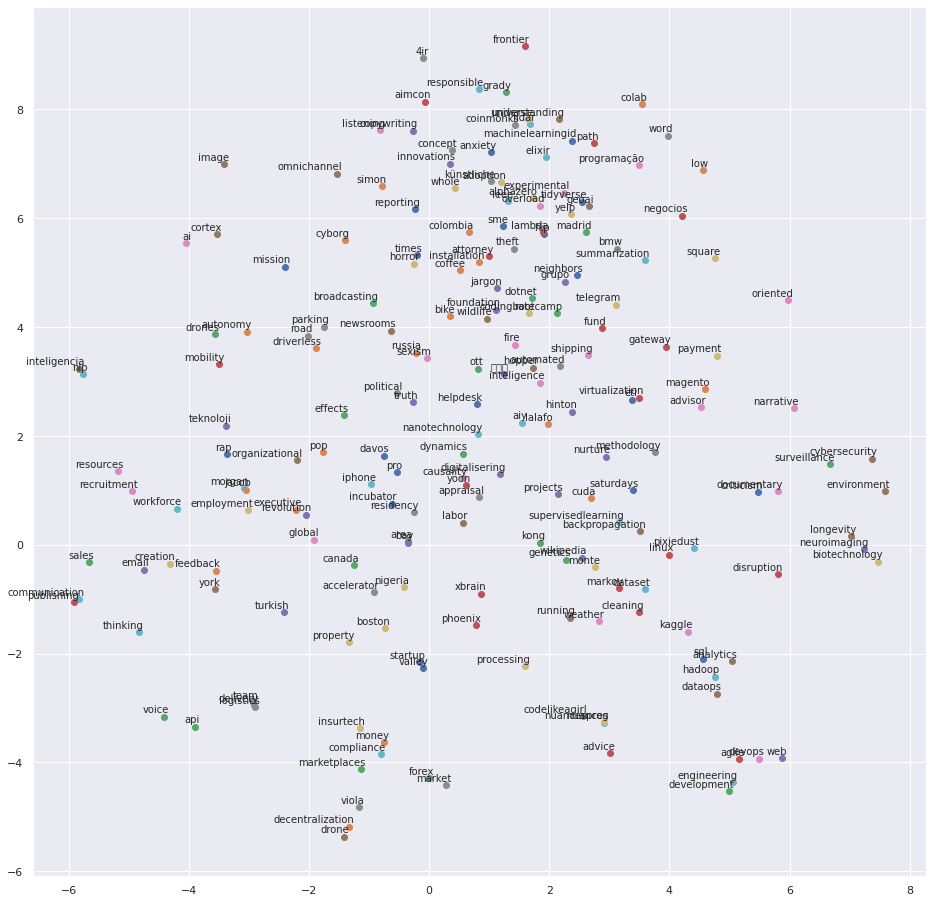

In [219]:
tsne_plot(model)

In [220]:
def display_closestwords_tsnescatterplot(model, word):

    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    # words= list(model.wv.vocab)[:500]
    # for word in words:
    tokens.append(model[word])
    labels.append(word)
    sim_words = model.wv.most_similar(word)
    for s_word in sim_words:
        tokens.append(model[s_word[0]])
        labels.append(s_word[0])

    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/home/manika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/home/manika/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


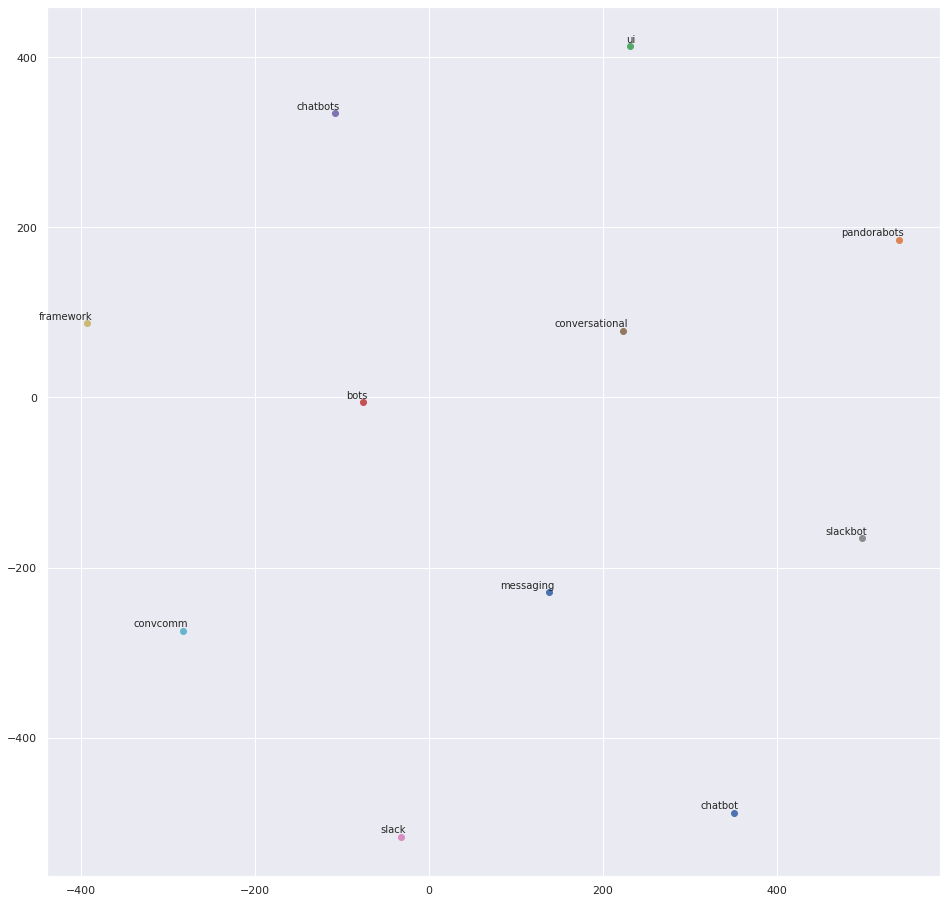

In [221]:
display_closestwords_tsnescatterplot(model, 'chatbot')